In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder

In [2]:
# define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [3]:
## EOSC410 Project
## Authors: Vanessa Yau + Christina Rutherford
saveIt = 1 # set to 1 to save all figs
LIM = 121

# import avalanche data for sea-to-sky region
avy_risk = pd.read_csv('sea-to-sky_JanApr_2016_avy.csv') #TODO do we need to normalize this data?
avy_date = avy_risk['Date']
tree = avy_risk['Treeline']; tree = np.array(tree)

# import era5 2m temp data
temp_2m = np.load('Sea-to-Sky_JanApr_2016_Temp2m.npy')
snowdep = np.load('Sea-to-Sky_JanApr_2016_SnowDepth.npy')

# import era5 coordinates
# coord = np.load('Sea-to-Sky_JanFeb2017_LatLon.npy', allow_pickle=True)
# lat = coord[0]
# lon = coord[1]

#Current Temp and Snow Depth data are (31, 7, 13). I averaged them below to be (31,) and eventually reshape them to (31,1), but this still 
#causes the variance to only be 1 mode in the center. Therefore maybe we don't do PCA 

# averaging TEMP from (31,7,13) to (31, 7) to (31,1)
temp_mean = np.mean(temp_2m,axis=(1,2))
# averaging SNOW from (31, 7, 13) to (31, 7) to (31, 1)
snowdep_mean = np.mean(snowdep,axis=(1,2))

if LIM != len(avy_date):
    avy_date = avy_date[:LIM]
    avy_risk = avy_risk[:LIM]
    tree = tree[:LIM]
    temp_mean = temp_mean[:LIM]
    snowdep_mean = snowdep_mean[:LIM]
    days = np.linspace(1,len(avy_date),len(avy_date))
else: 
    days = np.linspace(1,len(avy_date),len(avy_date))

In [4]:
# normalize data
temp_norm = (temp_mean - temp_mean.mean())/temp_mean.std()
snowdep_norm = (snowdep_mean - snowdep_mean.mean())/snowdep_mean.std()
# reshape data from (31,) to (31, 1)
temp_norm=temp_norm.reshape(-1, 1)
snowdep_norm=snowdep_norm.reshape(-1, 1)

In [5]:
# turn data into one hot vectors for categorical model
# treeline
enc_t = OneHotEncoder(max_categories=5).fit(tree.reshape(-1,1))
enc_t.categories_
t_cat = enc_t.transform(tree.reshape(-1,1)).toarray()

In [6]:
# ready for MLP, see MLP file
# define variables for MLP
N = len(days) # size of data
n_predictors = 2
predictors = np.c_[temp_norm,snowdep_norm]

target = t_cat
# loop through the 3 terrain categories for MLP on each
fracTrain = 0.8 # 80% of data used for training
NTrain = int(np.floor(fracTrain*N))
x_train = predictors[:NTrain]
y_train = target[:NTrain]

x_test = predictors[NTrain:]
y_test = target[NTrain:]

# y_out_ensemble_mean, y_out_ensemble, RMSE_ensemble_mean, RMSE_ensemble, nhn_best, nhl_best = MLP(x_train,y_train,x_test,y_test)
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 12 #maximum number of hidden neurons to loop through
max_hidden_layers = 1 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.001
max_iter = 1500 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation


y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []
all_models = []    ### NEW

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    models = []   ### NEW
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
            
            models.append(model) ### NEW
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    all_models.append(models[indBest]) ### NEW
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 BEST: 1 hidden layers, 4 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 BEST: 1 hidden layers, 9 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 #

In [7]:
### Now, we have a list of the best-performing models.
### First thing to do is save them. 
### This is really important if you're working with a partner & in the interest of making results repeatable 
### and just so you don't have to run the above code all the time
pickle.dump(all_models,open("treeline_model.p","wb"))

In [8]:
# transform y output back to categorical 1D array
t_model = enc_t.inverse_transform(y_test)

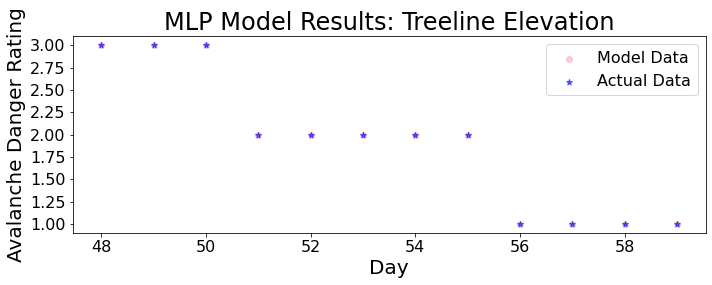

In [9]:
# plot models only
plt.figure(figsize=(10,4))
plt.scatter(days[NTrain:],t_model,alpha=0.8,color='pink',label='Model Data')
plt.scatter(days[NTrain:],tree[NTrain:],alpha=0.6,marker='*',color='blue',label='Actual Data')
plt.xlabel('Day', fontsize = 20)
plt.ylabel('Avalanche Danger Rating', fontsize = 20)
plt.xticks(fontsize = 16)
plt.xticks([0, 31, 60, 91, 121],['Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'Apr 30'])
plt.yticks(fontsize = 16)
plt.title('MLP Model Results: Treeline Elevation', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()
if saveIt:
    plt.savefig(f'fig_JanApr2017_model_results_treeline.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


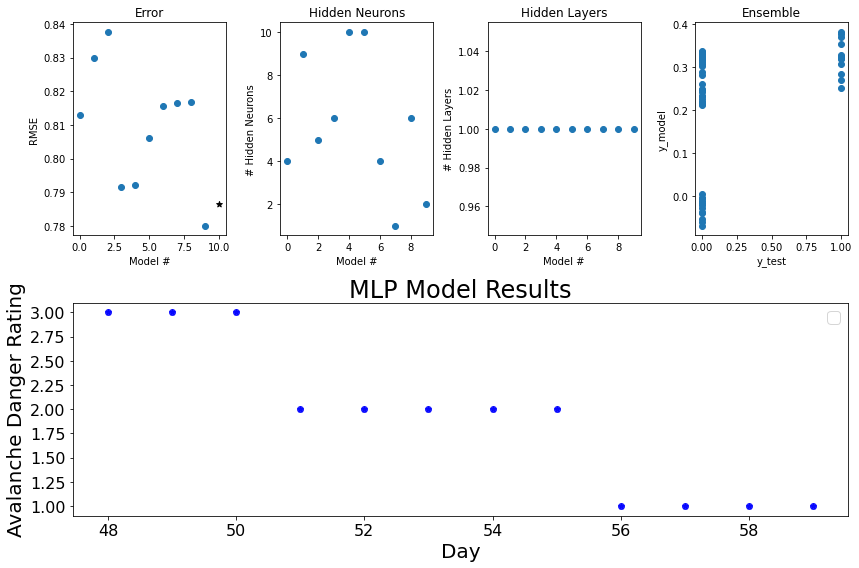

In [10]:
# plot
plt.figure(figsize=(12,8))
plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.scatter(days[NTrain:],tree[NTrain:],alpha=0.8,marker='*',color='b')
plt.scatter(days[NTrain:],t_model,alpha=0.8,color='b')
plt.xlabel('Day', fontsize = 20)
plt.ylabel('Avalanche Danger Rating', fontsize = 20)
plt.xticks(fontsize = 16)
plt.xticks([0, 31, 60, 91, 121],['Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'Apr 30'])
plt.yticks(fontsize = 16)
plt.title('MLP Model Results', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()
# if saveIt:
#     plt.savefig(f'fig_JanApr2017_model_results_treeline.png')